## Access Diver Site Information Qc (Parquet)
This Jupyter notebook demonstrates how to access and plot diver_site_information_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/e41efa35-03f0-4dea-be98-2a69e46b510b).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/diver_site_information_qc.ipynb).


In [1]:
dataset_name = "diver_site_information_qc"

## Install/Update packages and Load common functions

In [ ]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

In [2]:
from DataQuery import GetAodn

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:3217: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 44 ms, sys: 13.6 ms, total: 57.6 ms
Wall time: 8.52 s


In [4]:
aodn_dataset.dataset.partitioning.schema

polygon: string

## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


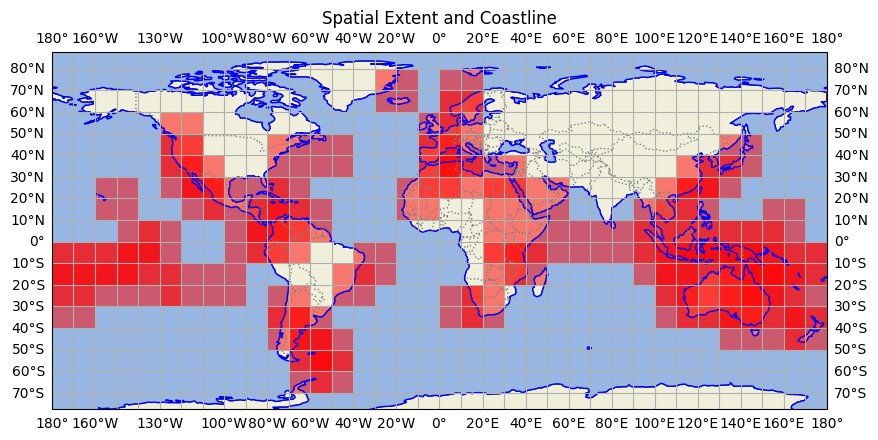

In [5]:
aodn_dataset.plot_spatial_extent()

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [6]:
%%time
aodn_dataset.get_temporal_extent()

ValueError: No known time variable ('TIME', 'JULD', 'detection_timestamp') found in dataset schema

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [7]:
metadata = aodn_dataset.get_metadata()
metadata

2025-11-11 11:35:53,565 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/diver_site_information_qc.parquet


{'country': {'type': 'string'},
 'area': {'type': 'string'},
 'location': {'type': 'string'},
 'site_code': {'type': 'string'},
 'site_name': {'type': 'string'},
 'old_site_codes': {'type': 'string'},
 'latitude': {'type': 'float32'},
 'longitude': {'type': 'float32'},
 'realm': {'type': 'string'},
 'province': {'type': 'string'},
 'ecoregion': {'type': 'string'},
 'lat_zone': {'type': 'string'},
 'programs': {'type': 'string'},
 'geom': {'type': 'string'},
 'filename': {'type': 'string',
  'units': '1',
  'long_name': 'Filename of the source file'},
 'polygon': {'type': 'string',
  'units': '1',
  'long_name': 'Spatial partition polygon'},
 'global_attributes': {'metadata_uuid': 'e41efa35-03f0-4dea-be98-2a69e46b510b',
  'dataset_name': 'diver_site_information_qc',
  'title': 'IMOS - National Reef Monitoring Network Sub-Facility - Site information'}}

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [8]:
%%time
df = aodn_dataset.get_data(
                           lat_min=-34, 
                           lat_max=-28, 
                           lon_min=151, 
                           lon_max=160, 
                               lat_varname="latitude",
                           lon_varname="longitude",
                           )

df.info()

2025-11-11 11:35:53,868 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/diver_site_information_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         268 non-null    object 
 1   area            268 non-null    object 
 2   location        268 non-null    object 
 3   site_code       268 non-null    object 
 4   site_name       268 non-null    object 
 5   old_site_codes  145 non-null    object 
 6   latitude        268 non-null    float32
 7   longitude       268 non-null    float32
 8   realm           268 non-null    object 
 9   province        268 non-null    object 
 10  ecoregion       268 non-null    object 
 11  lat_zone        268 non-null    object 
 12  programs        268 non-null    object 
 13  geom            268 non-null    object 
 14  filename        268 non-null    object 
 15  polygon         268 non-null    object 
dtypes: float32(2), object(14)
memory usage: 31.5+ KB
CPU times: user 75 ms, sys: 14.

In [9]:
df

,country,area,location,site_code,site_name,old_site_codes,latitude,longitude,realm,province,ecoregion,lat_zone,programs,geom,filename,polygon
0,Australia,New South Wales,Byron,CBMP1,Anemone mooring Julien Rocks,None,-28.610001,153.630005,Temperate Australasia,East Central Australian Shelf,Tweed-Moreton,Temperate,RLS,0101000020E61000005C8FC2F5283463405C8FC2F5289C...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...
1,Australia,New South Wales,Byron,CBMP2,Elwoods Mooring Julien Rocks,None,-28.610001,153.630005,Temperate Australasia,East Central Australian Shelf,Tweed-Moreton,Temperate,RLS,0101000020E61000005C8FC2F5283463405C8FC2F5289C...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...
2,Australia,New South Wales,Byron,CBMP3,The Wreck Main Beach,None,-28.639999,153.610001,Temperate Australasia,East Central Australian Shelf,Tweed-Moreton,Temperate,RLS,0101000020E6100000EC51B81E85336340A4703D0AD7A3...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...
3,Australia,New South Wales,Solitary Islands,PIMP1,Pimpernel Rock,None,-29.700001,153.399994,Temperate Australasia,East Central Australian Shelf,Tweed-Moreton,Temperate,RLS,0101000020E6100000CDCCCCCCCC2C63403333333333B3...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...
4,Australia,New South Wales,Solitary Islands,SI1,Elbow Cave Mooring N Solitary Is,1SI,-29.930000,153.389999,Temperate Australasia,East Central Australian Shelf,Tweed-Moreton,Temperate,RLS,0101000020E610000014AE47E17A2C6340AE47E17A14EE...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,Australia,New South Wales,Sydney,SYD67,Bare Island West Reef,None,-33.990002,151.229996,Temperate Australasia,East Central Australian Shelf,Manning-Hawkesbury,Temperate,RLS,0101000020E61000008FC2F5285CE762401F85EB51B8FE...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...
264,Australia,New South Wales,Sydney,SYD68,La Perouse Kelp Bed,None,-33.990002,151.229996,Temperate Australasia,East Central Australian Shelf,Manning-Hawkesbury,Temperate,RLS,0101000020E61000008FC2F5285CE762401F85EB51B8FE...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...
265,Australia,New South Wales,Sydney,SYD7,Berrys Bay Point,None,-33.849998,151.190002,Temperate Australasia,East Central Australian Shelf,Manning-Hawkesbury,Temperate,RLS,0101000020E6100000AE47E17A14E66240CDCCCCCCCCEC...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...
266,Australia,New South Wales,Sydney,SYD8,Shark Island SE,14SH,-33.860001,151.259995,Temperate Australasia,East Central Australian Shelf,Manning-Hawkesbury,Temperate,RLS,0101000020E6100000B81E85EB51E86240AE47E17A14EE...,ep_site_list_public_data.csv,0103000000010000000500000000000000008061400000...


In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_e41efa35-03f0-4dea-be98-2a69e46b510b_diver_site_information_qc_data-hash_aed4b73f.csv.zip

In [11]:
import folium
import seaborn as sns

ecoregions = df["ecoregion"].unique()
palette = sns.color_palette("tab10", len(ecoregions)).as_hex()
color_map = dict(zip(ecoregions, palette))

m = folium.Map(location=[-28.8, 153.5], zoom_start=5, tiles="CartoDB positron")

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color=color_map[row["ecoregion"]],
        fill=True,
        fill_opacity=0.8,
        popup=f"<b>{row['site_name']}</b><br>Ecoregion: {row['ecoregion']}",
    ).add_to(m)

m
